# Ramsey King
# DSC 550 - Data Mining
# November 20, 2021
# Term Project Milestone 5

### My term project will consist of being able to guess the main topic of sermons given by members of The Church of Jesus Christ of Latter Day Saints as defined by the designated topic assigned to it at speeches.byu.edu.  The ability to search for sermons by topic on this website is available.  While this specific case is not a business use case of data mining, there are many business use cases for being able to identify text by topic or keyword (i.e. www.google.com).  
### For purposes of this assignment, being able to quickly find topic related sermons is beneficial to members of the Church of Jesus Christ.  On occasion, members of the church are asked to give a sermon of their own on various topics, and having the ability to go to a resource and search the assigned topic by keyword helps to generate discussion points and give guidance as to what is appropriate to discuss.  For this project, we will limit the topics as defined by speeches.byu.edu. to give us an initial dataset of 800 rows before processing.  The topics and the count of the number of sermons given (as of October 4th, 2021) are: Life (108), Jesus Christ (106), Faith (100), Learning (97), and Service (73).  This should provide enough data to work with but if there is a need, additional topics will be included to help with the corpus.  

In [2]:
# Retrieve talks from topics page using BeautifulSoup

from bs4 import BeautifulSoup as bs
import requests
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

Now that we have BeautifulSoup imported, we will gather the links on the speeches.byu.edu website based on the topics listed above (Faith, Learning, Service, etc.).  

In [3]:
# Get list of urls for each of the topics

url = "https://speeches.byu.edu/topics/"

url_list = [
    'life/', 'jesus-christ/', 'faith/', 'learning/', 'service/'
]

links = []
new_links = []
# some of the links are repeated with '?M=V' and '?M=A' and those will be removed so we can have a unique set of links to pull talk information from.
for u in url_list:

    response = requests.get(url+u)
    html = response.content
    video = '?M=V'
    soup = bs(html, "lxml")
    for link in soup.findAll("a", attrs={'href': re.compile("^https://speeches.byu.edu/talks/[\D+]")}):
        links.append(link.get('href').replace(video, ''))

    audio = '?M=A'
    for link in links:
        new_link = link.replace(audio, '')
        new_links.append(new_link)
    new_links = list(set(new_links))



Now that the links have been gathered into a list, we will use this list to retrieve the individual sermon/talk/speech text from the respective link.  On a specific speech page, the following information will be gathered:
 - Speaker name
 - Talk title
 - Assigned topic
 - Date when the talk was given
 - The speaker's title (if they have a certain position within The Church of Jesus Christ of Latter Day Saints, Brigham Young University, etc.  If there is no position or title listed for the speaker, we will return 'Title Not Found')
 - The talk text

 This information will be combined into a dataframe for analysis.  This information will also be combined into a csv file in case work needs to be completed offline.

In [4]:
'''Retrieves talk text from each of the urls using beautiful soup.  Information such as the talk/sermon text, title, topic, date, and speaker will be retreived
and put into a dataframe.  A csv file will also be saved due to the time it takes to run or in case we need to work offline.'''
talk_text = []
title_text = []
topics = []
dates = []
speakers = []
speaker_position = []

for link in new_links:
    url = link
    response = requests.get(url)
    html = response.content
    soup = bs(html, 'lxml')
    temp_list = []

    link_splitter = link.split('/')
    speakers.append(link_splitter[4].replace('-', ' '))

    result = soup.find('p', class_='single-speech__speaker-subtext single-speech__speaker-position')
    speaker_position.append(result.text if result else 'Title Not Found')

    for div in soup.find_all('div', class_='single-speech__content'):
        talk_text.append(div.get_text(strip=True))
    for h1 in soup.find_all('h1', class_='single-speech__title'):
        title_text.append(h1.get_text(strip=True))        
    for p in soup.find_all('p', class_='single-speech__speaker-subtext single-speech__date'):
        dates.append(p.get_text(strip=True))
    for p in soup.find_all('p', class_='single-speech__related-tag'):
        temp_list.append(p.get_text(strip=True))
        temp_str = ','.join(temp_list)
    topics.append(temp_str)


dict = {'titles': title_text , 'speaker': speakers, 'speaker_position': speaker_position , 'date': dates, 'talks': talk_text, 'topics': topics, }
df = pd.DataFrame(dict)
df.to_csv('talks.csv')

Now that the talk information has been combined into a dataframe, we can begin pre-processing and gathering initial statistical information.  To begin, we will get the word count of each talk and place it in one of our columns.

In [5]:
# get word count of each talk
df['word_count'] = df['talks'].apply(lambda x: len(re.findall(r'\w+', x)))

Some talks have multiple topic associated with them on their webpage where the talk text was retrieved.  For purposes of this exercise (and project), we will take the first topic that is listed on the page and that will be our defining topic that will be used for analysis and modeling.  We will also create time columns (Month, Year, and month as an integer) to see if insights can be gained from them. 

In [6]:
# reduce the topic to the ones selected from our original selection ('life', 'jesus-christ', 'faith', 'learning', 'service')
from datetime import datetime
# the single_topic function takes the list of topics in the 'topics' column and will return the first topic it finds in the 'topic_selection_list'
def single_topic(dataframe_topics):
    column = [word for word in dataframe_topics.split(',')]
    the_string =  ', '.join([val for ind, val in enumerate(topic_selection_list) if val in column])
    return the_string.split(',')[0]

# removes the '/' from the url list and '-' from topics containing dashes such as 'jesus-christ'
topic_selection_list = [x[:-1].replace('-', ' ') for x in url_list]
df['topics'] = df['topics'].apply(lambda x: x.lower())
df['topic_singular'] = df['topics'].apply(single_topic)

# remove quotations ("") and all other punctuation from titles
df['titles'] = df['titles'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# create separate month and year column and create a number column representing the month 
df['month'] = df['date'].apply(lambda x: x.split(' ')[0])
# df['month_dt'] = df['month'].apply(lambda x: datetime.strptime(x, '%B'))
df['month_dt'] = pd.to_datetime(df['month'], format='%B')
df['year'] = df['date'].apply(lambda x: x.split(' ')[2]).astype(int)

def month_to_int(month_string):
    month_dictionary = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12
    }

    return month_dictionary.get(month_string)
    
df['month_number'] = df['month'].apply(month_to_int)

# get the dimensions of the dataset
df.shape


(458, 12)

Some of the webpages that data was scraped from did not have the talk text on the page.  Those will be removed from our dataframe.

In [7]:
# Remove the talks that do not contain any data.
print(df.shape)
df = df[df['talks'].str.contains('for this speech is unavailable')==False]
df.shape

(458, 12)


(379, 12)

At this time, we have an initial dataframe of information that we begin doing some statistical analysis on.  We will take a look at the dataframe.

In [8]:
# Take a peek at the data
df.reset_index(inplace = True, drop = True)
first_column = df.pop('topic_singular')
df.insert(0, 'topic_singular', first_column)
df.head(7)

,topic_singular,titles,speaker,speaker_position,date,talks,topics,word_count,month,month_dt,year,month_number
0,faith,Faith to Forgive Grievous Harms Accepting the ...,james r rasband,Dean of the J. Reuben Clark Law School,"October 23, 2012",Good morning. I must say I never imagined myse...,"atonement,faith,forgiveness,collection: jesus ...",4807,October,1900-10-01,2012,10
1,learning,Thy Mind O Man Must Stretch,john w welch,Title Not Found,"May 17, 2011",I am truly grateful for this recognition. And ...,"byu,learning",5569,May,1900-05-01,2011,5
2,jesus christ,Prophet Priest and King,john p hoffman,Professor in the BYU Department of Sociology,"May 8, 2012",It’s a pleasure to be here this morning to sha...,"jesus christ,collection: jesus christ, our sav...",4076,May,1900-05-01,2012,5
3,learning,A Celebration of Learning,cecil o samuelson,President of Brigham Young University,"September 9, 2008",It is my great pleasure to welcome you formall...,"education,learning",2661,September,1900-09-01,2008,9
4,faith,Faith and Science Symbiotic Pathways to Truth,jamie jensen,Associate Professor of Biology,"November 3, 2020","Good morning, students. Today, election day, i...","education,faith,learning,science,podcast: rece...",5479,November,1900-11-01,2020,11
5,jesus christ,Who Shall Declare His Generation,bruce r mcconkie,of the Quorum of the Twelve Apostles,"December 2, 1975",I have prayed and pondered earnestly to learn ...,"jesus christ,scriptures,testimony",3624,December,1900-12-01,1975,12
6,life,The Hope of Tomorrow,camilla e kimball,Title Not Found,"September 6, 1980","My brothers and sisters, I feel almost as if I...","life,righteousness",1730,September,1900-09-01,1980,9


Some initial statistical information.

In [9]:
# We want to get some inital statistical information from the dataset.
print("Describe Data")
print(df.describe())
print("Summarized Data")
print(df.describe(include=['O']))

Describe Data
        word_count         year  month_number
count   379.000000   379.000000    379.000000
mean   3935.548813  2002.815303      6.300792
std    1535.732421    12.862837      3.212784
min     317.000000  1968.000000      1.000000
25%    3216.000000  1994.000000      3.000000
50%    4060.000000  2005.000000      6.000000
75%    4850.500000  2013.000000      9.000000
max    8284.000000  2021.000000     12.000000
Summarized Data
       topic_singular             titles            speaker speaker_position  \
count             379                379                379              379   
unique              5                376                267              129   
top              life  Go Forth to Serve  cecil o samuelson  Title Not Found   
freq               89                  3                 13              108   

                   date                                              talks  \
count               379                                                379   

Based on the statistics, there is a talk that is duplicated.  We will find that talk and remove it from the dataset.

In [10]:
df = df[df['speaker'].str.contains('gordon b hinckley_greatest of these love')==False]
df.shape


(379, 12)

Initial plots will be created to see if any insights can be gained.  We will plot the following:
- talk word counts
- year the talk was given
- month the talk was given

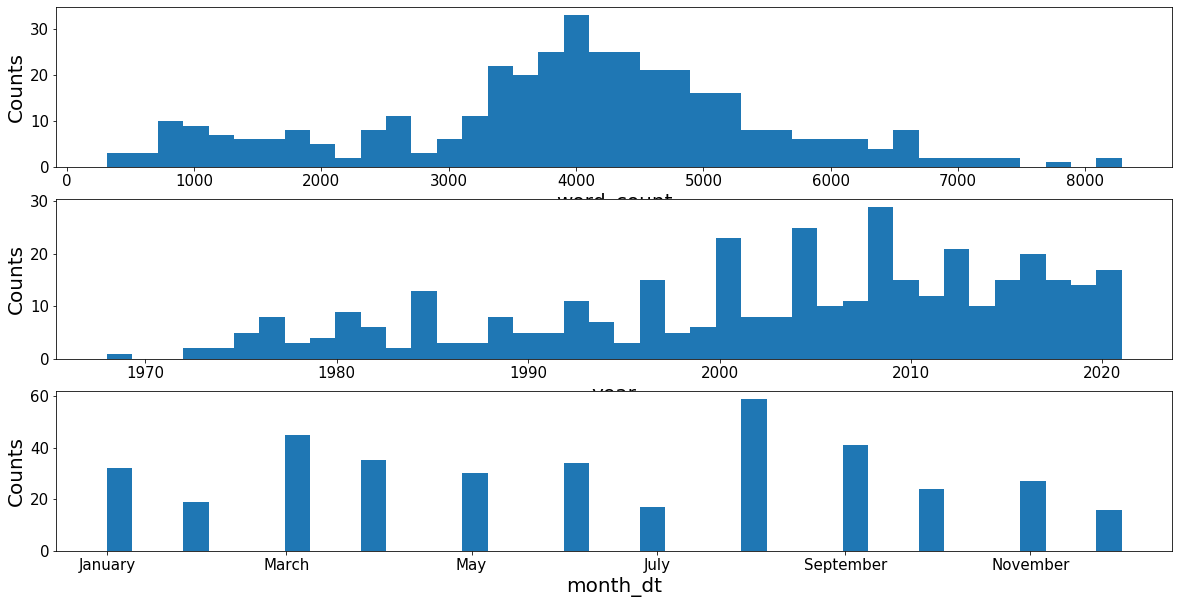

In [11]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 3, ncols = 1)

# Specify the features of interest
num_features = ['word_count', 'year', 'month_dt']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    if idx == 2:
        date_form = DateFormatter('%B')
        ax.xaxis.set_major_formatter(date_form)
        ax.hist(df[num_features[idx]].dropna(), bins=40)
        ax.set_xlabel(xaxes[idx], fontsize=20)
        ax.set_ylabel(yaxes[idx], fontsize=20)
        ax.tick_params(axis='both', labelsize=15)    
    else:
        ax.hist(df[num_features[idx]].dropna(), bins=40)
        ax.set_xlabel(xaxes[idx], fontsize=20)
        ax.set_ylabel(yaxes[idx], fontsize=20)
        ax.tick_params(axis='both', labelsize=15)

plt.show()

Based on the plot above, we can make a few observations:  
- The overall number of talks increased as time has gone on.
- August seems to be a popular month for people to give talks at Brigham Young University (suggesting that it coincides with the beginning of the school year)

The next plot will give us count by topic.

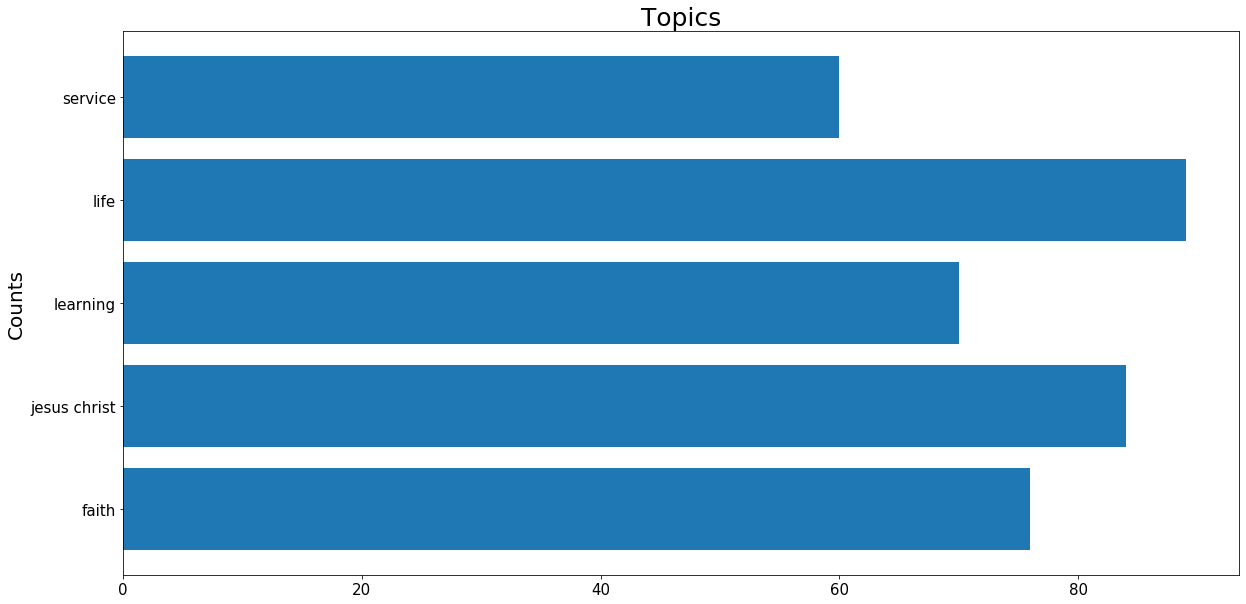

In [12]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visulizer
X_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['topic_singular']
Y_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['Counts']
# make the bar plot
axes.barh(X_Topics, Y_Topics)
axes.set_title('Topics', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)

plt.show()


Observations from the topics bar chart:
- Jesus Christ and Life are the most popular topics (of the most popular topics).  
- All of the most popular seem to fall in line with a private religious university

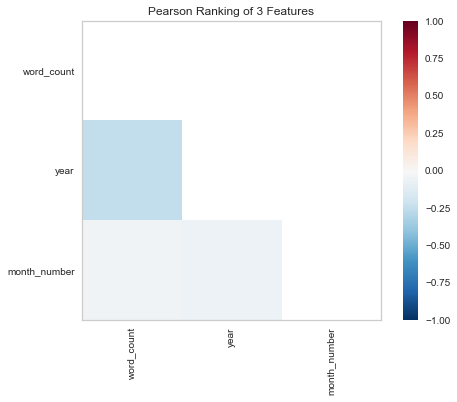

In [13]:
#set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

num_features = ['word_count', 'year', 'month_number']

# extract the numpy arrays from the data frame
X = df[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="pcoords1.png") # Draw/show/poof the data
plt.show()

A few observations from the Pearson Ranking matrix plot:
- As the years increase (become more recent to our day), the speakers seem to have more to say (use more words).
- The later in the year, the less sermons are given.  Maybe this is due to July being a summer month with not a lot of the student body present on campus, and December has winter break.

The next plot will show a bar chart of the most popular topics (Faith, Jesus Christ, Learning, Life, and Service) and what month they were given.

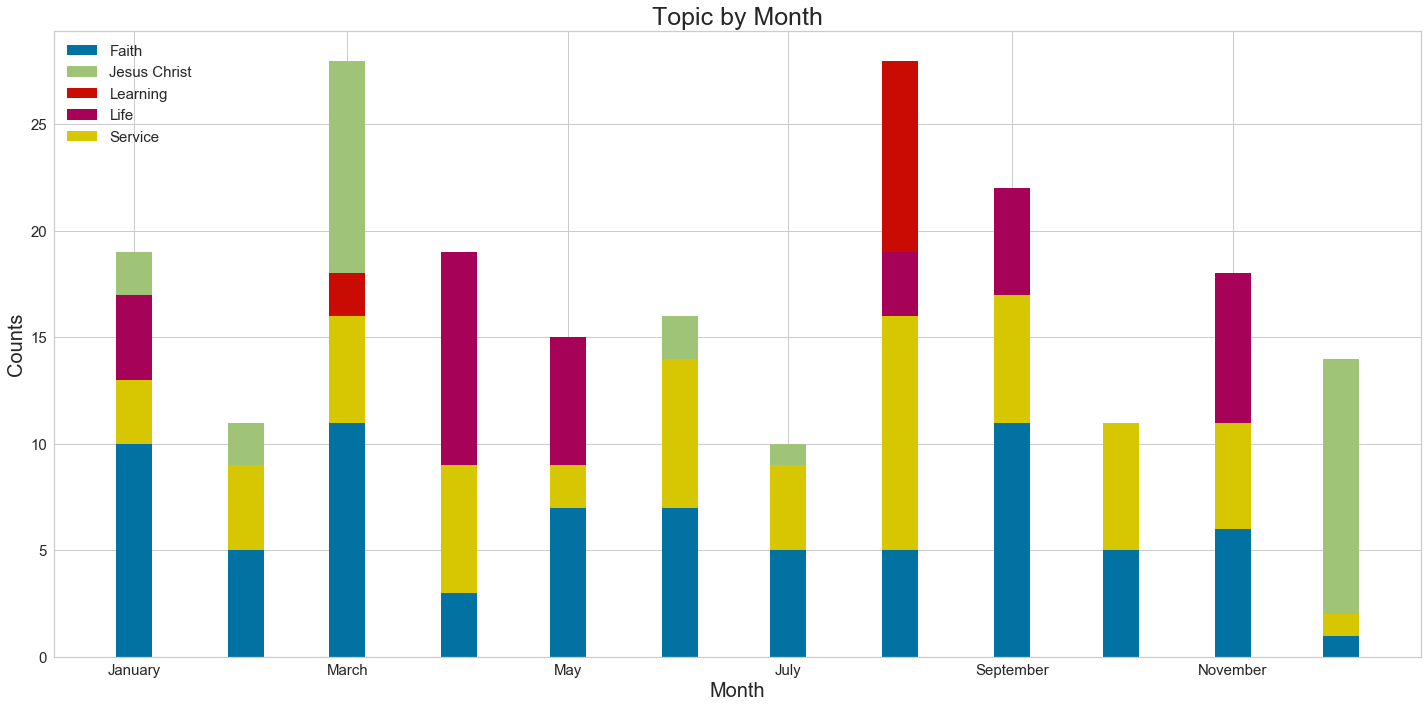

In [48]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visualizer
month_number_faith = df[df['topic_singular']=='faith']['month_dt'].value_counts()

month_number_jc = df[df['topic_singular']=='jesus christ']['month_dt'].value_counts()
month_number_jc = month_number_jc.reindex(index = month_number_faith.index)

month_number_learning = df[df['topic_singular']=='learning']['month_dt'].value_counts()
month_number_learning = month_number_learning.reindex(index = month_number_faith.index)

month_number_life = df[df['topic_singular']=='life']['month_dt'].value_counts()
month_number_life = month_number_life.reindex(index = month_number_faith.index)

month_number_service = df[df['topic_singular']=='service']['month_dt'].value_counts()
month_number_service = month_number_service.reindex(index = month_number_faith.index)

# make the bar plot
p1 = axes.bar(month_number_faith.index, month_number_faith.values, width=10)
p2 = axes.bar(month_number_jc.index, month_number_jc.values, bottom=month_number_faith.values, width=10)
p3 = axes.bar(month_number_learning.index, month_number_learning.values, bottom=month_number_faith.values, width=10)
p4 = axes.bar(month_number_life.index, month_number_life.values, bottom=month_number_faith.values, width=10)
p5 = axes.bar(month_number_service.index, month_number_service.values, bottom=month_number_faith.values, width=10)

axes.set_title('Topic by Month', fontsize=25)
axes.xaxis.set_major_formatter(DateFormatter('%B'))
axes.set_xlabel('Month', fontsize=20)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)
axes.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Faith', 'Jesus Christ', 'Learning', 'Life', 'Service'), fontsize = 15)

plt.tight_layout()
plt.show()


The following observations can be made from the chart above:

- August is the most popular month for talks, with an overwhelming majority of the learning topics being contained there.
- December is a popular month to discuss Jesus Christ (more than likely due to Christmas).
- Faith and Service is a common theme no matter the time of year.
- Jesus Christ as a topic is popular in March (perhaps due to Easter?).

It will be interesting as we continue on with this project how these variables will play into the predictability of the project.

In Milestone 2, you should drop any features that are not useful for your model building. You should explain and justify why the feature dropped is not useful. You should address any missing data issues. Build any new features that you need for your model, e.g., create dummy variables for categorical features if necessary. Explain your process at each step. You can use any methods/tools you think are most appropriate. Again, keep in mind that this may look very different from what is done in the Titanic tutorial case study. You should do what makes sense for your project. Be careful to avoid data snooping in these steps.

Build any new features that you need for your model, e.g., create dummy variables for categorical features if necessary.

We will now create dummy variables for the categorical designations in the topic_singular column that will be later used for model analysis.  Instead of using a dictionary to assign values to the categories (i.e. adversity = 1, divine potential = 2, etc.), we will use the get_dummies section so that the model will not give more importance to a higher number.

In [50]:
# Assign the singular topics an number ID for model analysis

# df = pd.get_dummies(df, prefix='topic_singular', columns=['topic_singular'])
df.head(7)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 0 to 378
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   topic_singular    379 non-null    object        
 1   titles            379 non-null    object        
 2   speaker           379 non-null    object        
 3   speaker_position  379 non-null    object        
 4   date              379 non-null    object        
 5   talks             379 non-null    object        
 6   topics            379 non-null    object        
 7   word_count        379 non-null    int64         
 8   month             379 non-null    object        
 9   month_dt          379 non-null    datetime64[ns]
 10  year              379 non-null    int32         
 11  month_number      379 non-null    int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(8)
memory usage: 37.0+ KB


In Milestone 3, you will begin the process of model selection and evaluation. In addition, write step-by-step instructions for performing the model evaluation and selection part of your case study.

In Milestone 3, you should build and evaluate at least one model. You can use any methods/tools you think are most appropriate, but you should explain/justify why you are choosing the model(s) and evaluation metric(s) you choose. It is important to think about what type of model and metric makes sense for the context of your problem. If you are familiar with hyperparameter tuning, this would also be a great addition to your project.

Write a short overview/conclusion of the insights gained from your model building/evaluation.

There is a little more processing that we would like to take care before building our model. First we will lower case all
the words so words like 'Hello' and 'hello' can be treated the same.

In [51]:
# Lower case, remove stop words, and stem the talk text

df['talks_lowered'] = df['talks'].apply(lambda x: x.lower())
# df['talks_lowered'][1]

Prior to model selection, we will tokenize our talks with sentences, words, and part-of-speech tagging.

In [52]:
# tokenization of the speeches into sentences.
from nltk.tokenize import sent_tokenize

df['sentence_tokenize'] = df['talks'].apply(lambda x: sent_tokenize(x))

In [53]:
# tokenization of the speeches into words
from nltk.tokenize import word_tokenize
df['word_tokenize'] = df['talks'].apply(lambda x: word_tokenize(x))

In [54]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
data = []

for i in range(df.shape[0]):
    text = df.iloc[i,14]
    talk_processed_list = []
    for word in text:
        if word not in set(stopwords.words('english')):
            talk_processed_list.append(stemmer.stem(word))
    proc_talk = " ".join(talk_processed_list)
    data.append(proc_talk)

# print(data[1], len(data))

In [55]:
# pos 
import nltk
# nltk.download('averaged_perceptron_tagger')

df['word_pos'] = df['word_tokenize'].apply(lambda x: nltk.pos_tag(x))

We are now ready to build our model.  The model that we will build first is a Naive Bayes model.  The steps were adapted from a blog post on medium.com entitled "Text classification using the BagOfWords Approach with NLTK and Scikit Learn."
The actual code from the blog post can be found at https://github.com/CharlesRajendran/TextClassification/blob/master/classifier.py

The reason why this model was chosen is because the Naive Bayes model is a common model used when dealing with text
classification.  It was also used as the code is straightforward enough to follow and get a model created.

In [56]:
# adapted from CharlesRajendran TextClassification github

# creating the feature matrix
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(data).toarray()
y = df.iloc[:, 0]
print(X.shape, y)

(379, 1000) 0             faith
1          learning
2      jesus christ
3          learning
4             faith
           ...     
374    jesus christ
375    jesus christ
376            life
377           faith
378         service
Name: topic_singular, Length: 379, dtype: object


In [57]:
# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=7)

The Naive Bayes model will now be used.

In [58]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

Our predictions will now be made.

In [59]:
# predict class

y_pred = classifier.predict(X_test)

We can now move onto the analytics portion of our Naive Bayes model.  We will look at the confusion matrix, the classification report (which includes precision, recall, f1-score), and the accuracy.

              precision    recall  f1-score   support

       faith       0.46      0.50      0.48        22
jesus christ       0.78      0.69      0.73        26
    learning       0.25      0.27      0.26        11
        life       0.50      0.46      0.48        26
     service       0.33      0.40      0.36        10

    accuracy                           0.51        95
   macro avg       0.46      0.47      0.46        95
weighted avg       0.52      0.51      0.51        95


0.5052631578947369


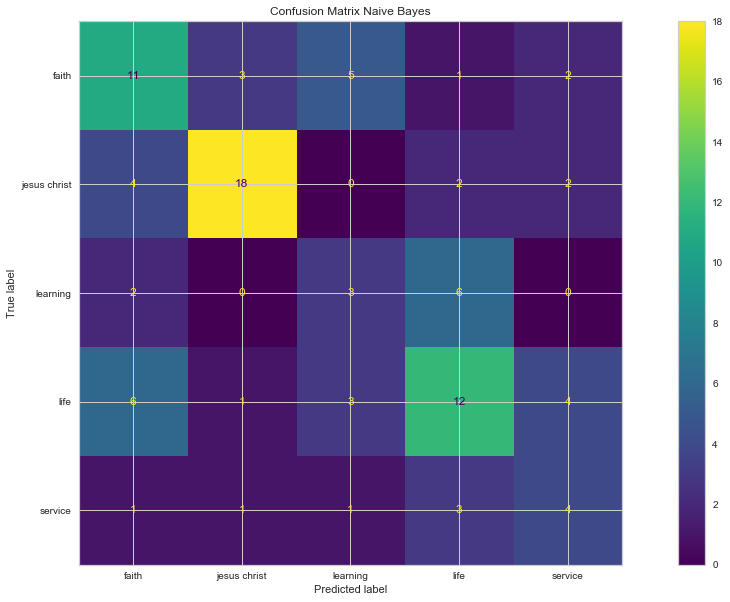

In [60]:
# Confusion matrix, classification report, accuracy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# print(cm)
# print()
print(cr)
print()
print(accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.title("Confusion Matrix Naive Bayes")
plt.show()

Based on this model, we have an accuracy of 50.5%.  

We will now build a (Support Vector Machine) model.  The reason why this model is chosen is because of a Teams post by Ryan Long and Ori Rinamman that discusses "Factors to consider when choosing a predictive model."  On the post, there was a reference to the following website:

https://scikit-learn.org/dev/tutorial/machine_learning_map/index.html

On the scikit learn website, there is a flowchart that one can follow to help them determine the best model to use.  Based on the results of the flowchart, it lead to using a Support Vector Machine model.

              precision    recall  f1-score   support

       faith       0.67      0.73      0.70        22
jesus christ       0.85      0.65      0.74        26
    learning       0.54      0.64      0.58        11
        life       0.59      0.65      0.62        26
     service       0.44      0.40      0.42        10

    accuracy                           0.64        95
   macro avg       0.62      0.61      0.61        95
weighted avg       0.66      0.64      0.64        95


0.6421052631578947


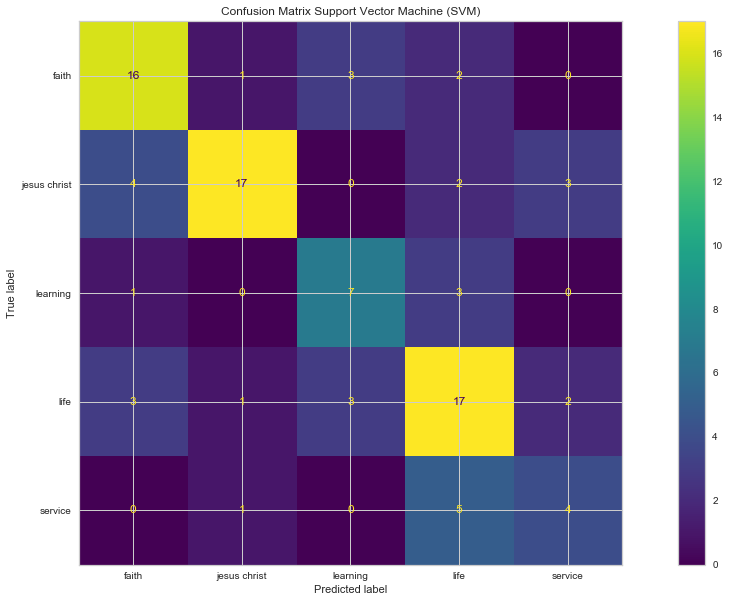

In [61]:
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay

svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=['faith', 'jesus christ', 'learning', 'life', 'service'])
cr = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(cr)
print()
print(accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot()
plt.title("Confusion Matrix Support Vector Machine (SVM)")
plt.show()


The accuracy of the SVM model is 60.2% while the Naive Bayes model has an accuracy of 50.5%.  Because of this, we will move forward with the SVM model.  I will try some different kernels to see if the initial accuracy is improved.  

In [62]:
#RBF Kernal
from sklearn import svm
svm_classifier = svm.SVC(kernel='rbf', gamma=1, C=1)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(cm)
print()
print(cr)
print()
print(accuracy)

[[ 0  0  0 22  0]
 [ 0  0  0 26  0]
 [ 0  0  0 11  0]
 [ 0  0  0 26  0]
 [ 0  0  0 10  0]]

              precision    recall  f1-score   support

       faith       0.00      0.00      0.00        22
jesus christ       0.00      0.00      0.00        26
    learning       0.00      0.00      0.00        11
        life       0.27      1.00      0.43        26
     service       0.00      0.00      0.00        10

    accuracy                           0.27        95
   macro avg       0.05      0.20      0.09        95
weighted avg       0.07      0.27      0.12        95


0.2736842105263158


C:\Users\Ramsey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ramsey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ramsey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The RBF kernal returns an accuarcy of 27.8%.  We will now look at the Sigmoid kernel.

In [63]:
# Sigmoid kernal

from sklearn import svm
svm_classifier = svm.SVC(kernel='sigmoid', C=1)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(cm)
print()
print(cr)
print()
print(accuracy)

[[ 9  3  3  7  0]
 [ 2 17  0  6  1]
 [ 0  0  7  4  0]
 [ 4  2  0 19  1]
 [ 0  0  0  7  3]]

              precision    recall  f1-score   support

       faith       0.60      0.41      0.49        22
jesus christ       0.77      0.65      0.71        26
    learning       0.70      0.64      0.67        11
        life       0.44      0.73      0.55        26
     service       0.60      0.30      0.40        10

    accuracy                           0.58        95
   macro avg       0.62      0.55      0.56        95
weighted avg       0.62      0.58      0.58        95


0.5789473684210527


The sigmoid kernal returns an accuracy of 57.8%.  Now we will look at a polynomial kernel.

In [64]:
# Polynomial

from sklearn import svm
svm_classifier = svm.SVC(kernel='poly', C=1)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(cm)
print()
print(cr)
print()
print(accuracy)

[[ 8  0  1 12  1]
 [ 2 12  0 12  0]
 [ 0  0  1 10  0]
 [ 2  1  0 23  0]
 [ 0  0  0  8  2]]

              precision    recall  f1-score   support

       faith       0.67      0.36      0.47        22
jesus christ       0.92      0.46      0.62        26
    learning       0.50      0.09      0.15        11
        life       0.35      0.88      0.51        26
     service       0.67      0.20      0.31        10

    accuracy                           0.48        95
   macro avg       0.62      0.40      0.41        95
weighted avg       0.63      0.48      0.47        95


0.4842105263157895


The polynomial accuarcy is 48.4%, so we will go back to the linear kernel and see if any tuning can take place.

In [65]:
from sklearn.model_selection import GridSearchCV

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'sigmoid']}  
   
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(X_train, y_train) 
 
# print best parameter after tuning 
print('The best parameters are: '+ str(grid.best_params_)) 
grid_predictions = grid.predict(X_test) 
   
# print classification report 
print(classification_report(y_test, grid_predictions)) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The best parameters are: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

       faith       0.67      0.73      0.70        22
jesus christ       0.85      0.65      0.74        26
    learning       0.54      0.64      0.58        11
        life       0.59      0.65      0.62        26
     service       0.44      0.40      0.42        10

    accuracy                           0.64        95
   macro avg       0.62      0.61      0.61        95
weighted avg       0.66      0.64      0.64        95



By tuning, we were able to acheive an accuracy of 64%.  Now we will try an N-GRAMS model to see if accuracy can be improved in comparison to the tuned linear model.

In [66]:
# Trying an n-grams model.
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

stemmer = SnowballStemmer('english')
stop_words = stopwords.words('english')

df['processed_text'] = df['talks'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub('[^a-zA-Z]', " ", x).split() if i not in stop_words]).lower())
# df['processed_text'][0]


Top 10 keywords per class: 
faith: miracl trust emphasi ad pandem uncertainti trust lord doubt faith faith faith trust god
jesus christ: savior lord jesus repent messiah redeem templ aton flesh mighti grace
learning: studi faith aim scholarship theori intellig mentor learn studi congratul learner learn
life: god godhead god desir campaign green equip road safe minor market spous
service: poor forth serv fellow million touch serv stranger selfless relief societi servic
accuracy score: 0.5526315789473685
f1_score: 0.8068823481972774
recall: 0.8065870348865755
precision: 0.8080286918385813
[[50  3  2  6  1]
 [ 2 56  1  3  1]
 [ 2  2 52  5  1]
 [ 5  7  8 50  3]
 [ 1  0  0  7 35]]
              precision    recall  f1-score   support

       faith       0.64      0.50      0.56        14
jesus christ       0.66      0.90      0.76        21
    learning       0.32      0.88      0.47         8
        life       0.50      0.12      0.20        16
     service       0.70      0.41      0.52 

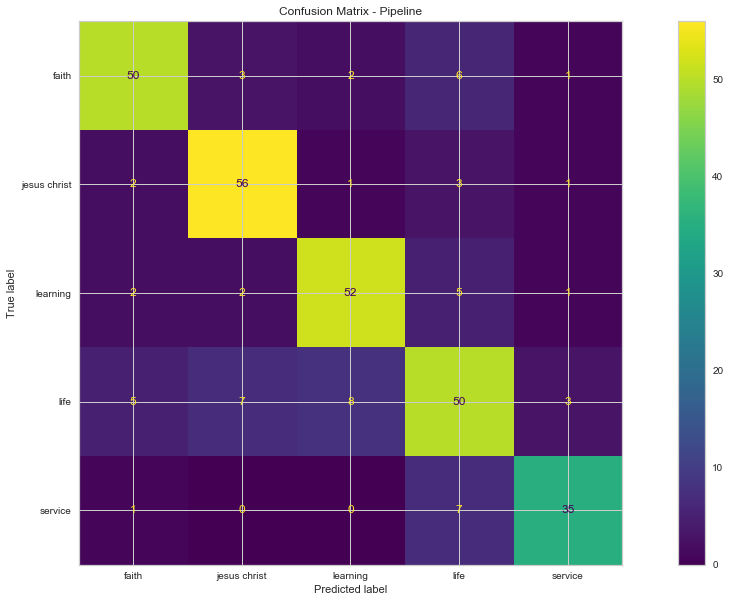

In [67]:
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df.topic_singular, test_size=0.2)

pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,3), stop_words='english', sublinear_tf=True)),
('chi', SelectKBest(chi2, k=10000)),
('clf', LinearSVC(C=3, penalty='l1', max_iter=3000, dual=False))
])

model = pipeline.fit(X_train, y_train)
predicted_values = model.predict(X_train)

vectorizer = model.named_steps['vect']
chi = model.named_steps['chi']
clf = model.named_steps['clf']

feature_names = vectorizer.get_feature_names_out()
feature_names = [feature_names[i] for i in chi.get_support(indices=True)]
feature_names = np.asarray(feature_names)

target_names = ['faith', 'jesus christ', 'learning', 'life', 'service']

print("Top 10 keywords per class: ")
for i, label in enumerate(target_names):
    top10 = np.argsort(clf.coef_[i])[-10:]
    print('%s: %s' % (label, " ".join(feature_names[top10])))



print("accuracy score: " + str(model.score(X_test, y_test)))
print("f1_score: " + str(f1_score(y_train, predicted_values, average='macro')))
print("recall: " + str(recall_score(y_train, predicted_values, average='macro')))
print("precision: " + str(precision_score(y_train, predicted_values, average='macro')))
print(str(confusion_matrix(y_train, predicted_values)))
print(classification_report(y_test, model.predict(X_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, predicted_values), display_labels=svm_classifier.classes_)
disp.plot()
plt.title("Confusion Matrix - Pipeline")
plt.show()

We were able to acheive only an accuracy of 55.2% using the n-gram Pipeline, so the tuned linear model turns out being the best model for this corpora.